In [1]:
import pandas as pd
import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tinyshift.stats import BootstrapBCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.exceptions import NotFittedError
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from tinycp.regressor import ConformalizedRegressor
from tinycp.plot import plot_prediction_intervals
from tinyshift.stats import RobustGaussianScaler, FeatureResidualizer, filter_features_by_vif
from tinyshift.plot import corr_barplot, corr_heatmap

# EDA

## Feature Selection
- avgAnnCount: Mean number of reported cases of cancer diagnosed annually
    - The diagnosis could demonstrate people having a minimal medical treatment.
- incidenceRate: Mean per capita (100,000) cancer diagnoses
    - The diagnosis could demonstrate people having a minimal medical treatment.
- PctPrivateCoverage: Percent of county residents with private health coverage 
    - People that has private health insurance can have a better medical treatment.
- PctPublicCoverage: Percent of county residents with government-provided health coverage 
    - An urge of public health system usage could be a indicative of less people can afford a private health coverage.
- PctBachDeg25_Over: Percent of county residents ages 25 and over highest education attained: bachelor’s degree 
	- Higher education can be an indicative of more income.
- PercentMarried: Percent of county residents who are married 
	- Residents who are married can indicate two incomes in the family, possibly affording the private coverage.
- binnedInc: Median income per capita binned by decile
	- what would I do with this column? Discrete?
- povertyPercent: Percent of populace in poverty
    - Less chance of getting any treatment
- medianIncome: Median income per county
    - Higher median income can be an indicative of less inequality 
- MedianAge: Median age of female county residents 
	- An elderly population may indicate difficulty in facing more severe cancer
- PctWhite
    - Only inputted to help the model to review the social inequality context. Still don't know if it shouldn't be included.
- PctBlack
    - Only inputted to help the model to review the social inequality context. Still don't know if it shouldn't be included.
- PctAsian
    - Only inputted to help the model to review the social inequality context. Still don't know if it shouldn't be included.
- PctOtherRace
    - Only inputted to help the model to review the social inequality context. Still don't know if it shouldn't be included.
- avgDeathsPerYear
    - Number of reported mortalities due to cancer to "adjust" the estimation
- popEst2015
    - Estimate population to "adjust" the estimation

In [2]:
df = pd.read_csv("./data/cancer_reg.csv", encoding='iso-8859-1')

In [3]:
#df = pd.get_dummies(df, columns=['binnedInc'], dtype=int) # Explode. One-hot encoding for binnedInc

In [4]:
df = df[df['MedianAge'] <= 90]

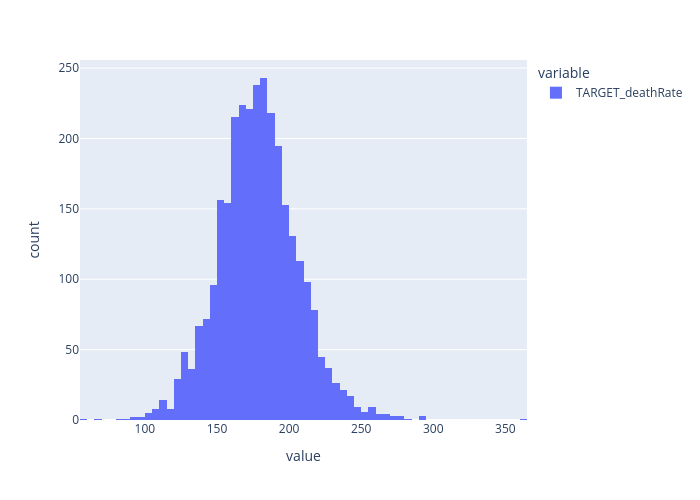

In [5]:
fig = px.histogram(df["TARGET_deathRate"])
fig.show("png")

In [6]:
df["TARGET_deathRate"].var() > df["TARGET_deathRate"].mean()

True

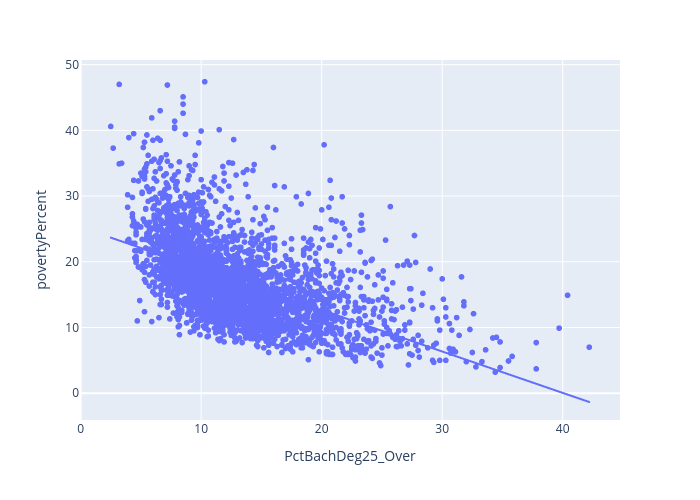

In [7]:
px.scatter(df, x='PctBachDeg25_Over', y='povertyPercent', trendline='ols').show("png")

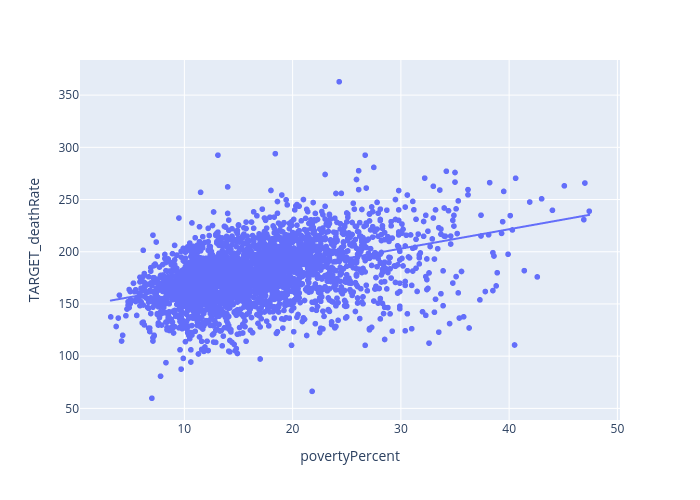

In [8]:
px.scatter(df, x='povertyPercent', y='TARGET_deathRate', trendline='ols').show("png")

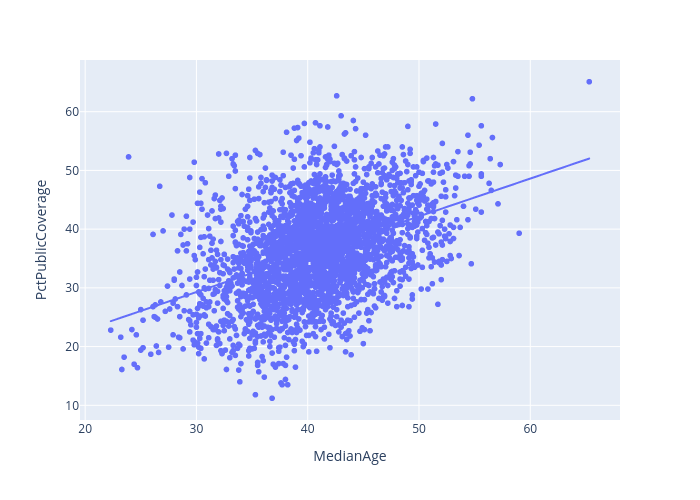

In [9]:
px.scatter(df, x='MedianAge', y='PctPublicCoverage', trendline='ols').show("png")

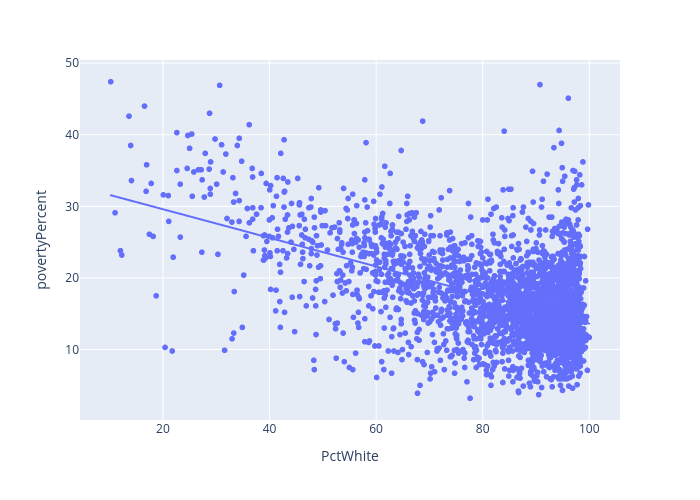

In [10]:
px.scatter(df, x='PctWhite', y='povertyPercent', trendline='ols').show("png")

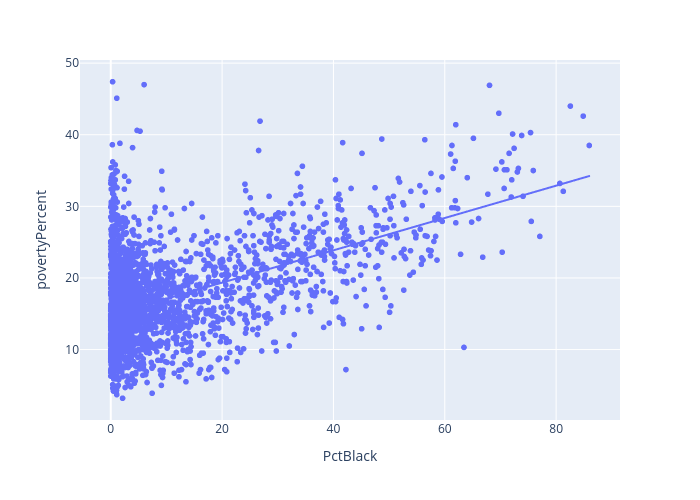

In [11]:
px.scatter(df, x='PctBlack', y='povertyPercent', trendline='ols').show("png")

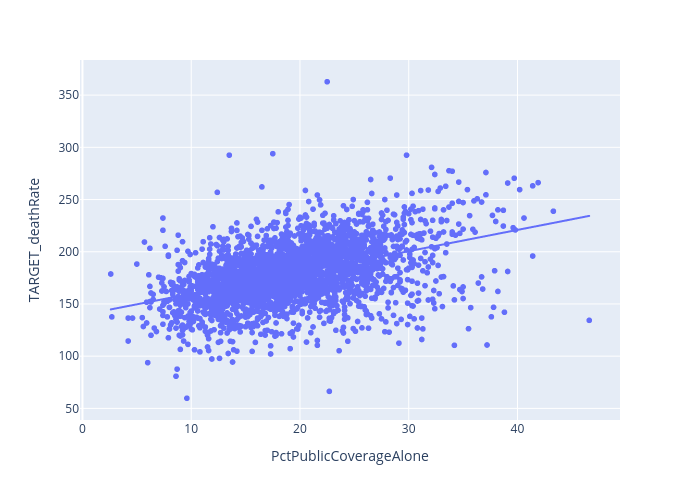

In [12]:
px.scatter(df, x='PctPublicCoverageAlone', y='TARGET_deathRate', trendline='ols').show("png")

## Percentage of Total of NaN Data for Each Column

In [13]:
df.isnull().sum() / len(df)

avgAnnCount                0.000000
avgDeathsPerYear           0.000000
TARGET_deathRate           0.000000
incidenceRate              0.000000
medIncome                  0.000000
popEst2015                 0.000000
povertyPercent             0.000000
studyPerCap                0.000000
binnedInc                  0.000000
MedianAge                  0.000000
MedianAgeMale              0.000000
MedianAgeFemale            0.000000
Geography                  0.000000
AvgHouseholdSize           0.000000
PercentMarried             0.000000
PctNoHS18_24               0.000000
PctHS18_24                 0.000000
PctSomeCol18_24            0.750083
PctBachDeg18_24            0.000000
PctHS25_Over               0.000000
PctBachDeg25_Over          0.000000
PctEmployed16_Over         0.049387
PctUnemployed16_Over       0.000000
PctPrivateCoverage         0.000000
PctPrivateCoverageAlone    0.199536
PctEmpPrivCoverage         0.000000
PctPublicCoverage          0.000000
PctPublicCoverageAlone     0

In [14]:
df = df.drop(columns=["PctSomeCol18_24", "PctPrivateCoverageAlone"])

## CI

In [15]:
bca = BootstrapBCA()
bca.compute_interval(df["PctEmployed16_Over"].dropna(), confidence_level=0.95, statistic=np.mean, n_resamples=1000)

(53.82614569603778, 54.43873685962987)

In [16]:
df["PctEmployed16_Over"] = df["PctEmployed16_Over"].fillna(np.ceil(df["PctEmployed16_Over"].mean()))

In [17]:
features_in = [
"avgAnnCount",
"PctPrivateCoverage",
"PctPublicCoverage",
"PctBachDeg25_Over",
"PercentMarried",
"incidenceRate",
"povertyPercent",
"MedianAge",
"medIncome",
"PctWhite",
"PctBlack",
"PctAsian",
"PctOtherRace",
"avgDeathsPerYear",
]
target = "TARGET_deathRate"

# Modelling

In [18]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [19]:
scaler = RobustGaussianScaler()
residualizer = FeatureResidualizer()

In [20]:
df_train = df_train.astype({x: float for x in features_in})
df_test = df_test.astype({x: float for x in features_in})

In [21]:
df_train.loc[:, features_in]  = scaler.fit_transform(df_train[features_in])
df_test.loc[:, features_in]  = scaler.transform(df_test[features_in])

In [22]:
df_train.loc[:, features_in] = residualizer.fit_transform(df_train[features_in], corrcoef=0.70)
df_test.loc[:, features_in] = residualizer.transform(df_test[features_in])

In [23]:
model = LinearRegression()

In [24]:
model.fit(df_train[features_in], df_train[target])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [25]:
def standardize_coefficients(model: LinearRegression, df_train: pd.DataFrame):
    """
    Standardize the coefficients of the model based on the standard deviation of the features and target.
    """
    std_coef = np.zeros(len(model.coef_))
    for i in range(len(model.feature_names_in_)):
        std_coef[i] = model.coef_[i] * df_train[model.feature_names_in_[i]].std() / df_train[target].std()
    return std_coef

In [26]:
model.feature_importance_ = standardize_coefficients(model, df_train)
feature_importance = pd.DataFrame({
    'feature': model.feature_names_in_,
    'std_coef': model.feature_importance_
}).sort_values(by='std_coef', ascending=False).reset_index(drop=True)
feature_importance

,feature,std_coef
0,incidenceRate,0.384866
1,PctPublicCoverage,0.185282
2,avgDeathsPerYear,0.182727
3,PctBlack,0.066841
4,povertyPercent,0.031627
5,PercentMarried,-0.008531
6,PctWhite,-0.017400
7,MedianAge,-0.045943
8,PctAsian,-0.056709
9,medIncome,-0.097875


In [28]:
y_pred = model.predict(df_test[features_in])
mse = mean_squared_error(df_test[target], y_pred)
r2 = r2_score(df_test[target], y_pred)
mse, r2

(415.1184310156673, 0.47843215554133833)

In [ ]:
mask = filter_features_by_vif(df_train[features_in]).tolist()
filtered_features = np.array(features_in)[mask].tolist()

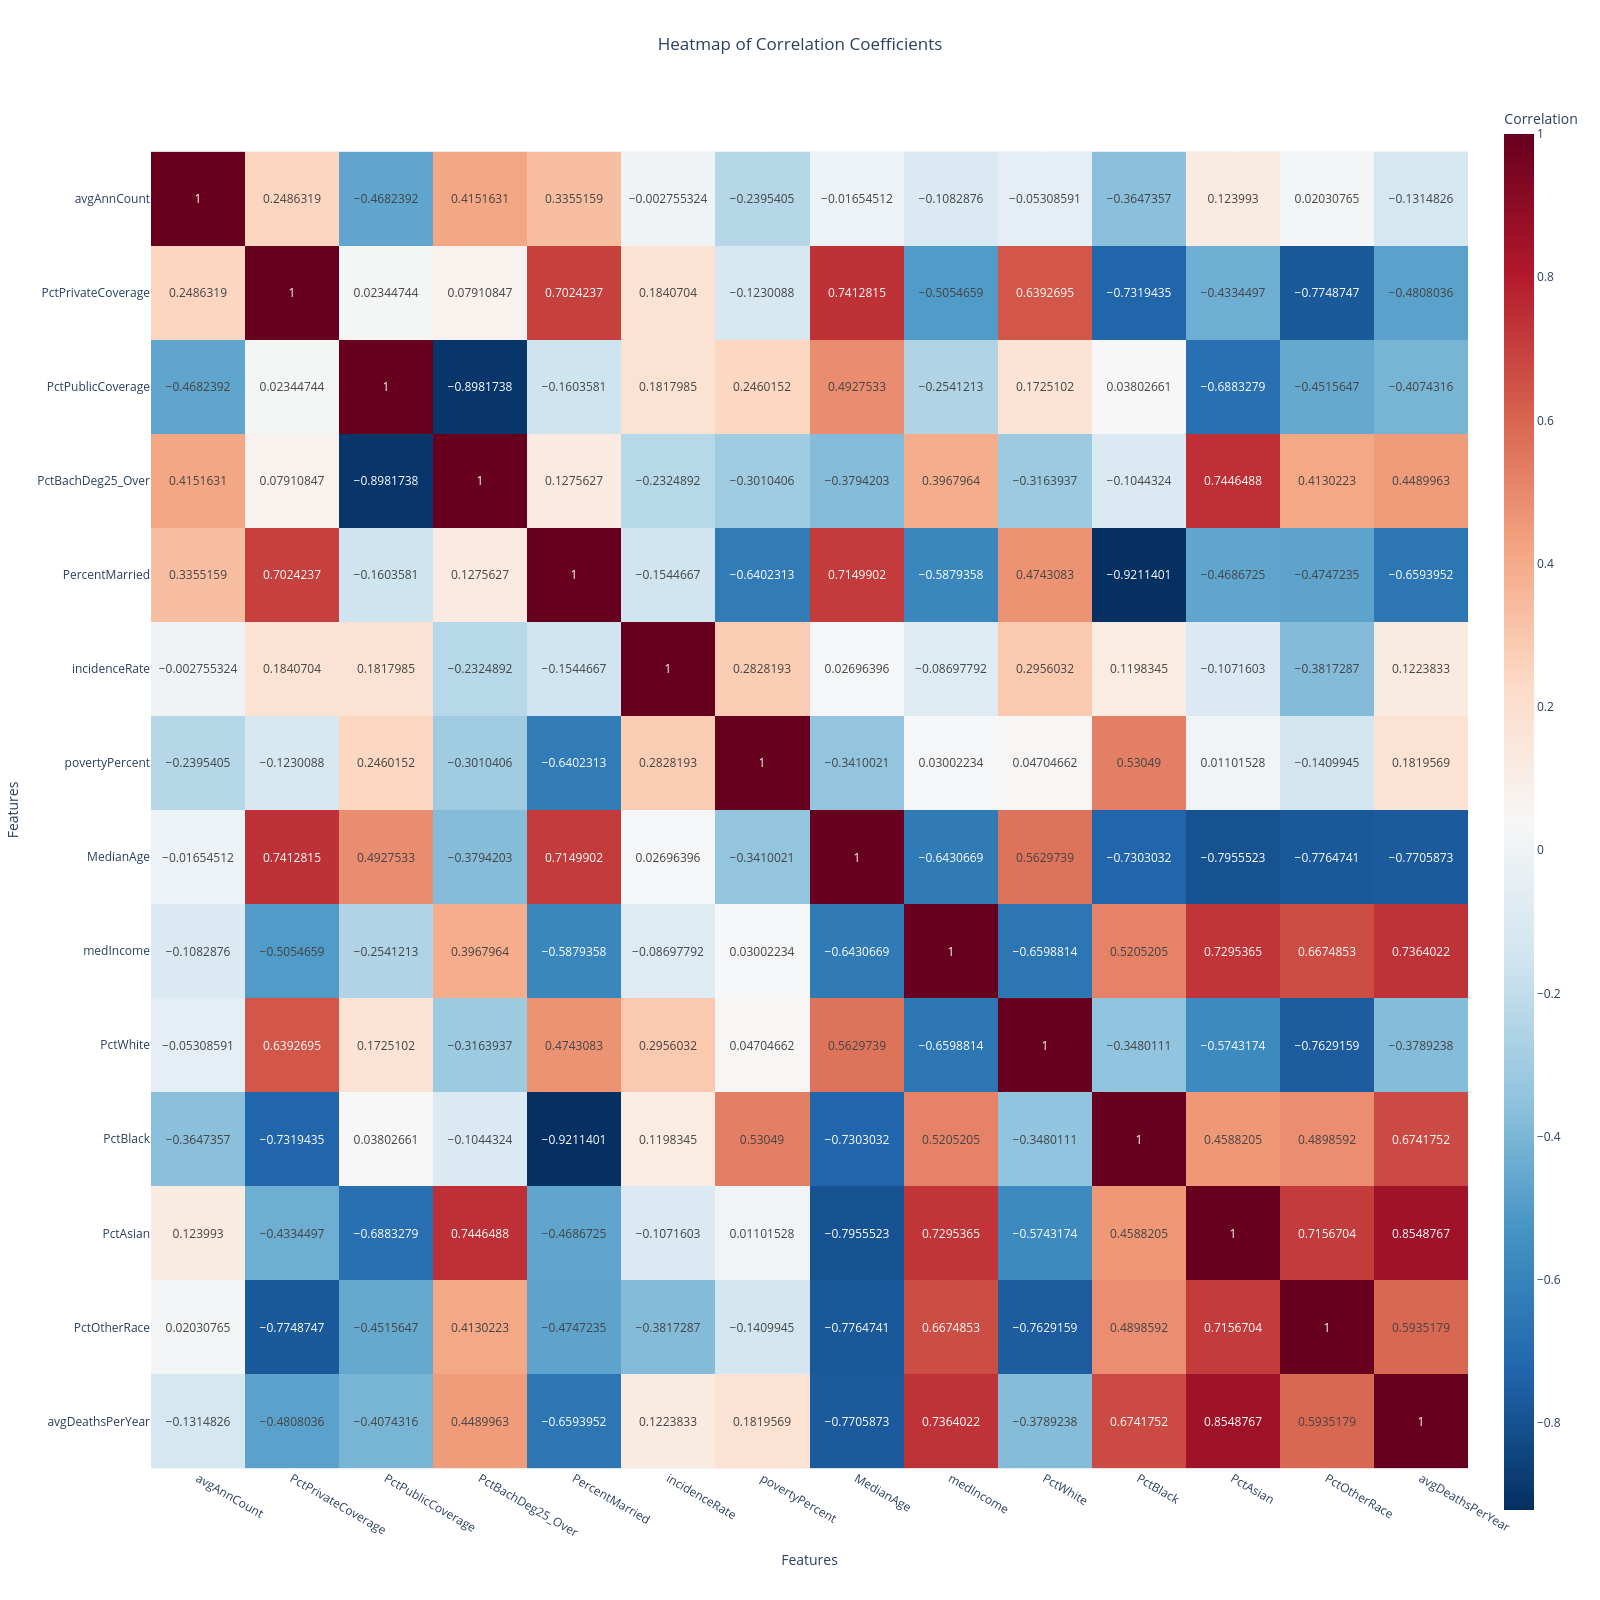

In [31]:
corr_heatmap(df_train[filtered_features].corr(numeric_only=True), fig_type="png")

In [32]:
def generate_vif_dataframe(df, features):

    def _vif_rank(data):
        if 1 < data < 5:
            return "Low"
        elif 5 <= data < 15:
            return "Moderate"
        elif 15 <= data < 20:
            return "High"
        elif 20 <= data < 30:
            return "Very High"
        return "Extreme"
    
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i) for i in range(df[features].shape[1])]
    vif_data["Tolerance"] = 1 / vif_data["VIF"]
    vif_data["VIF Rank"] = vif_data["VIF"].apply(_vif_rank)
    return vif_data

In [62]:
generate_vif_dataframe(df_train, features_in).sort_values(by="Tolerance")

,feature,VIF,Tolerance,VIF Rank
2,PctPublicCoverage,3.148762,0.317585,Low
7,MedianAge,3.071989,0.325522,Low
4,PercentMarried,3.037746,0.329191,Low
3,PctBachDeg25_Over,2.839431,0.352183,Low
1,PctPrivateCoverage,2.831125,0.353216,Low
11,PctAsian,2.589907,0.386114,Low
13,avgDeathsPerYear,2.331100,0.428982,Low
10,PctBlack,1.966452,0.508530,Low
6,povertyPercent,1.794654,0.557211,Low
9,PctWhite,1.704385,0.586722,Low


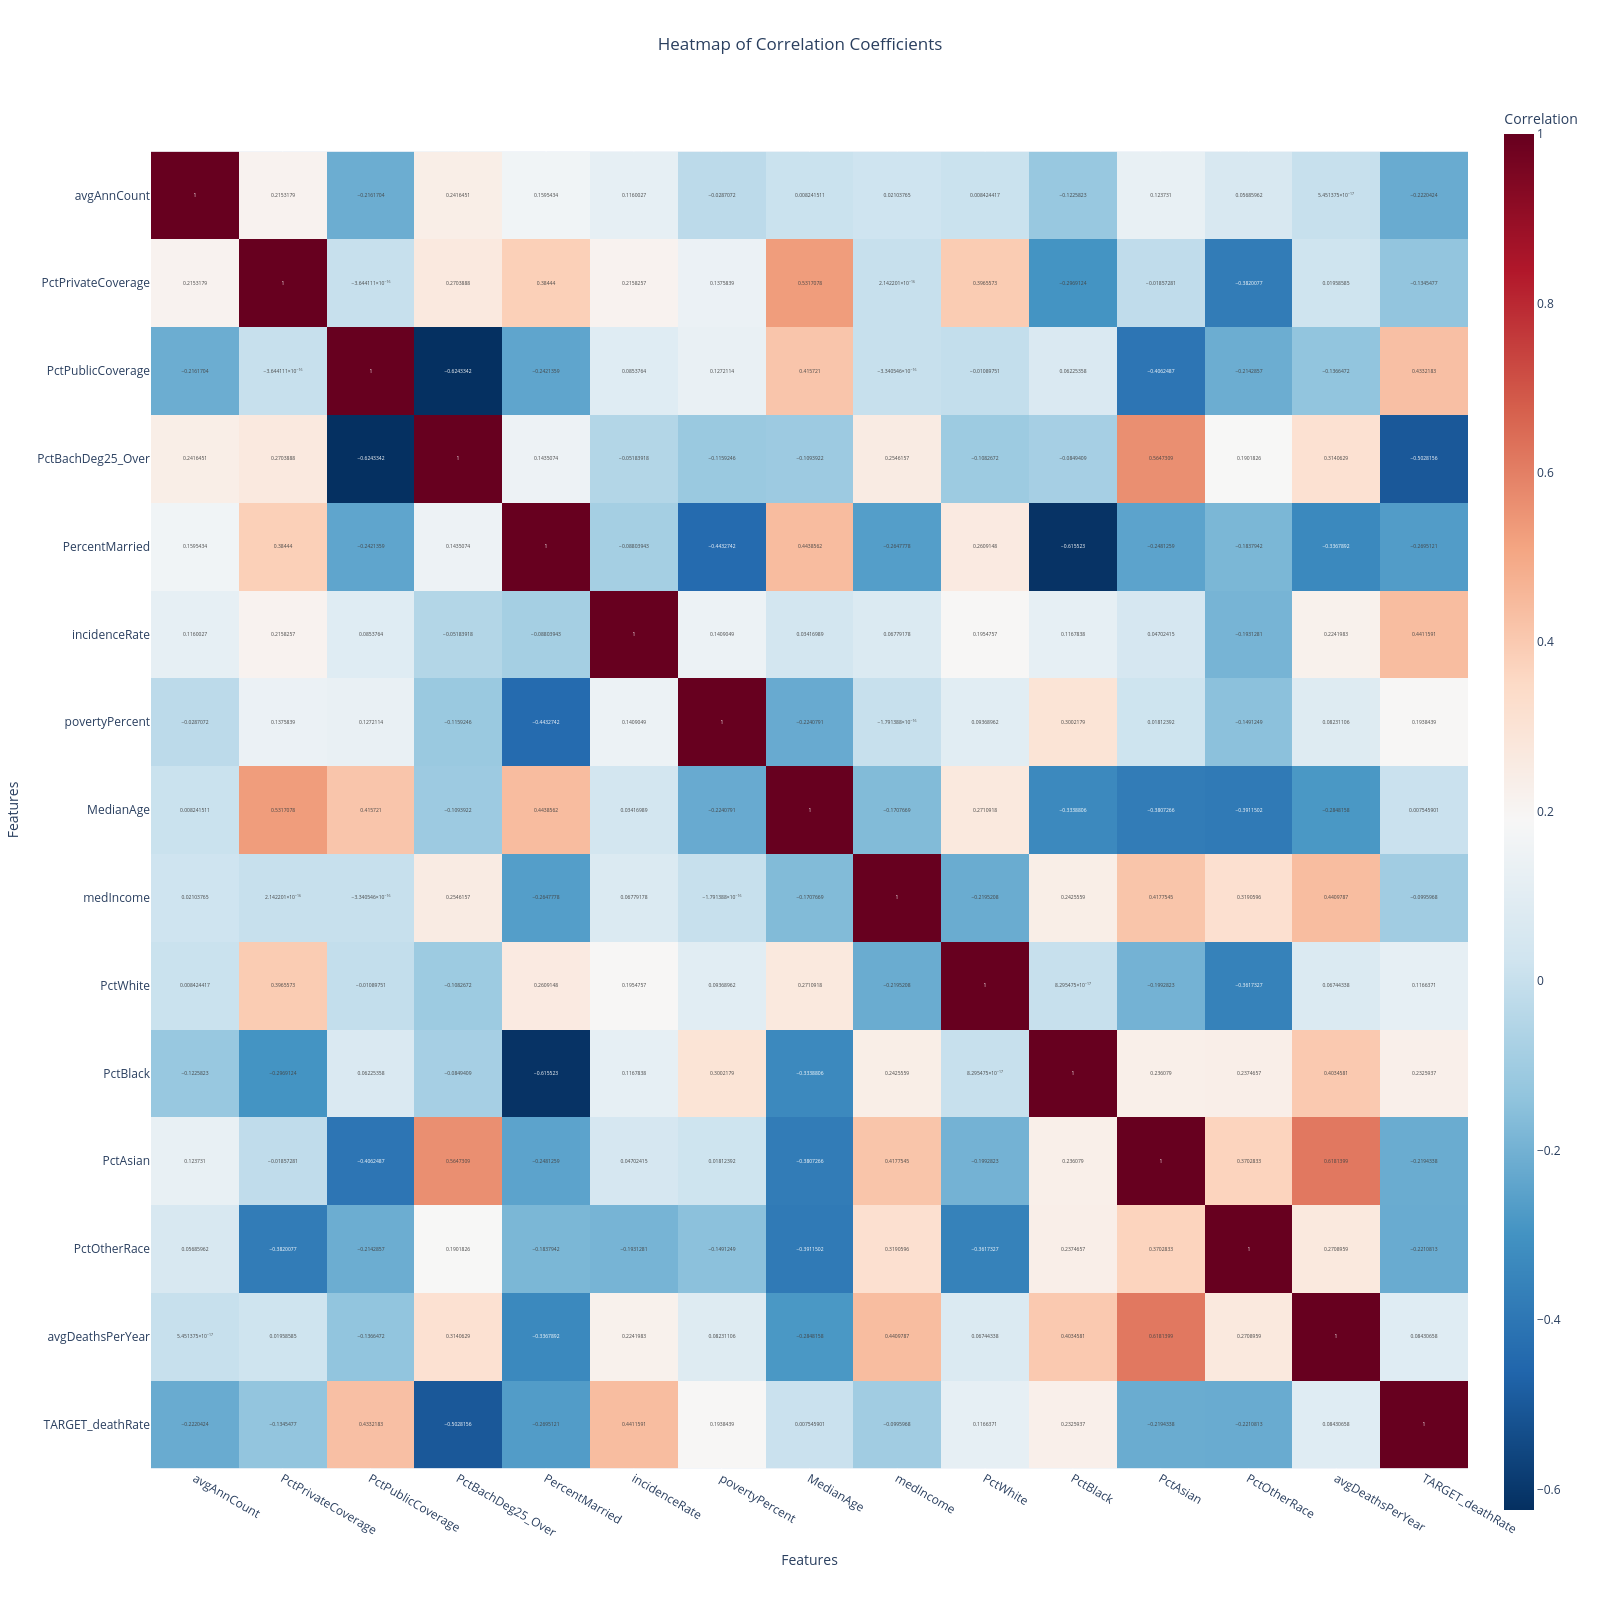

In [34]:
corr_heatmap(df_train[filtered_features + ["TARGET_deathRate"]], width=1600, height=1600, fig_type="png")

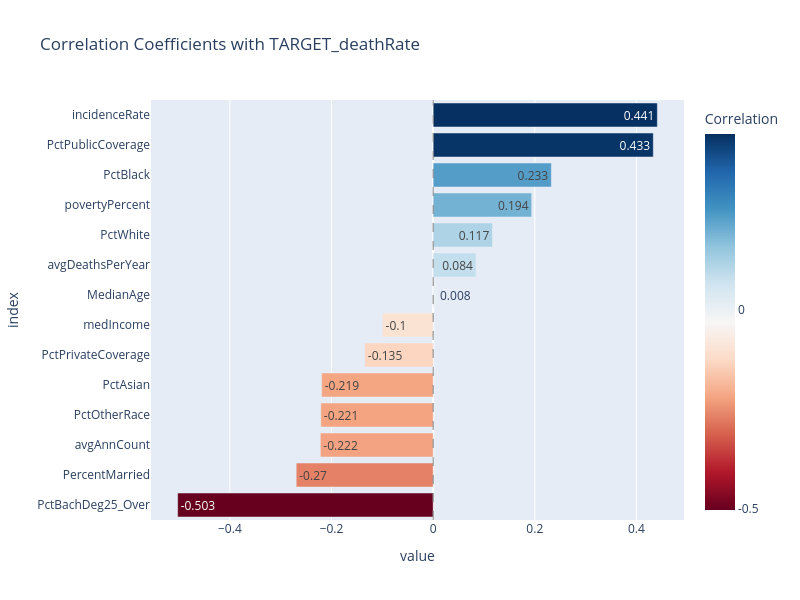

In [35]:
corr_barplot(df_train[filtered_features], df_train['TARGET_deathRate'], fig_type="png")

In [36]:
model = LinearRegression()

In [37]:
model.fit(df_train[filtered_features], df_train[target])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [38]:
y_pred = model.predict(df_test[filtered_features])
y_test = df_test[target]

In [39]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse, r2

(415.1184310156673, 0.47843215554133833)

<Axes.ArtistList of 2 lines>

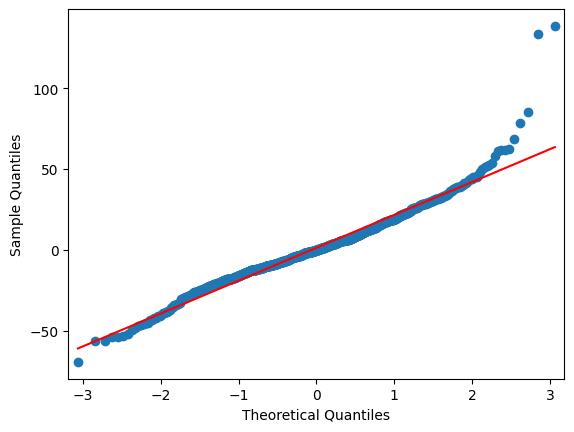

In [40]:
residuals = y_test - y_pred
qqplot(residuals, line='s').gca().lines

In [41]:
# Goldfeld-Quandt test
gq_test = het_goldfeldquandt(residuals, df_test[filtered_features])
print("Goldfeld-Quandt test:")
print(f"F-stat: {gq_test[0]}, p-value: {gq_test[1]}\n")

Goldfeld-Quandt test:
F-stat: 0.9341601917999122, p-value: 0.7620859709783844



In [42]:
dw = durbin_watson(residuals)
print(f"Durbin-Watson statistic:", dw)

# DW ≈ 2: No autocorrelation.
# DW < 2: Possible positive autocorrelation.
# DW > 2: Possible negative autocorrelation.

Durbin-Watson statistic: 1.9357458651878803


In [43]:
def standardize_coefficients(model: LinearRegression, df_train: pd.DataFrame):
    """
    Standardize the coefficients of the model based on the standard deviation of the features and target.
    """
    std_coef = np.zeros(len(model.coef_))
    for i in range(len(model.feature_names_in_)):
        std_coef[i] = model.coef_[i] * df_train[model.feature_names_in_[i]].std() / df_train['TARGET_deathRate'].std()
    return std_coef

In [44]:
model.feature_importance_ = standardize_coefficients(model, df_train)

In [45]:
feature_importance = pd.DataFrame({
    'feature': model.feature_names_in_,
    'std_coef': model.feature_importance_
}).sort_values(by='std_coef', ascending=False).reset_index(drop=True)
feature_importance

,feature,std_coef
0,incidenceRate,0.384866
1,PctPublicCoverage,0.185282
2,avgDeathsPerYear,0.182727
3,PctBlack,0.066841
4,povertyPercent,0.031627
5,PercentMarried,-0.008531
6,PctWhite,-0.017400
7,MedianAge,-0.045943
8,PctAsian,-0.056709
9,medIncome,-0.097875


In [46]:
X = sm.add_constant(df_train[filtered_features]) # add intercept
y = df_train[target]
model_sm = sm.OLS(y, X).fit()
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       TARGET_deathRate   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     161.4
Date:                Sun, 03 Aug 2025   Prob (F-statistic):          4.38e-320
Time:                        18:44:13   Log-Likelihood:                -9220.9
No. Observations:                2111   AIC:                         1.847e+04
Df Residuals:                    2096   BIC:                         1.856e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                178.3220      0.417    427.686      0.000     177.504     179.140
avgAnnCount           -4.6761      0.727     -6.435      0.000      -6.101      -3.251
PctPrivateCoverage    -4.9780      1.033     -4.817      0.000      -7.005      -2.951
PctPublicCoverage      5.0986      0.740      6.891      0.000       3.648       6.549
PctBachDeg25_Over     -7.7299      0.703    -11.002      0.000      -9.108      -6.352
PercentMarried        -0.2348      0.727     -0.323      0.747      -1.660       1.190
incidenceRate         10.5907      0.463     22.897      0.000       9.684      11.498
povertyPercent         1.5668      1.006      1.558      0.119      -0.405       3.539
MedianAge             -1.2642      0.731     -1.730      0.084      -2.697       0.169
medIncome             -6.9997      1.333     -5.250      0.000      -9.614      -4.385
PctWhite              -0.7613      0.866     -0.880      0.379      -2.459       0.936
PctBlack               1.8393      0.585      3.146      0.002       0.693       2.986
PctAsian              -1.5605      0.671     -2.326      0.020      -2.876      -0.245
PctOtherRace          -3.5453      0.538     -6.593      0.000      -4.600      -2.491
avgDeathsPerYear       5.0282      0.637      7.899      0.000       3.780       6.277
==============================================================================
Omnibus:                      183.017   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              733.016
Skew:                           0.340   Prob(JB):                    6.72e-160
Kurtosis:                       5.805   Cond. No.                         6.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Multiple Linear Regression: Dividing by binnedInc

In [47]:
def generate_regression_models_by_binned_inc(df, features,target='TARGET_deathRate', binned_col='binnedInc'):
    """
    Create a multiple linear regression model for each bin of the binned income column.
    """
    models = {}
    for bin_value in df[binned_col].unique():
        df_bin = df[df[binned_col] == bin_value]
        model = LinearRegression()
        models[bin_value] = model.fit(df_bin[features], df_bin[target])
    return models


In [48]:
multi_models = generate_regression_models_by_binned_inc(df_train, filtered_features)

In [49]:
def evaluate_regression_models(models, df_test, features, target='TARGET_deathRate', binned_col='binnedInc'):
    """
    Evaluate multiple regression models on the test set.
    """
    results = {}
    for bin_value in models:
        df_bin = df_test[df_test[binned_col] == bin_value]
        y_pred = models[bin_value].predict(df_bin[features])
        y_test = df_bin[target]
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[bin_value] = {'mse': mse, 'r2': r2}
    return pd.DataFrame(results).T

In [50]:
evaluate_regression_models(multi_models, df_test, filtered_features)

,mse,r2
"(54545.6, 61494.5]",294.229798,0.233888
"[22640, 34218.1]",120.059714,0.887143
"(42724.4, 45201]",457.646495,0.301106
"(48021.6, 51046.4]",300.483268,0.289500
"(51046.4, 54545.6]",276.764585,0.318855
"(40362.7, 42724.4]",501.539508,0.201322
"(61494.5, 125635]",483.114129,0.266556
"(45201, 48021.6]",465.407788,0.321223
"(37413.8, 40362.7]",687.421306,0.363835
"(34218.1, 37413.8]",399.502646,0.343835


In [51]:
def generate_qqplot_by_binned_inc(models, df_test, features):
    """
    Generate QQ plots for the residuals of each regression model.
    """
    binned_col = 'binnedInc'
    for bin_value in models:
        df_bin = df_test[df_test[binned_col] == bin_value]
        y_pred = models[bin_value].predict(df_bin[features])
        y_test = df_bin['TARGET_deathRate']
        residuals = y_test - y_pred
        qqplot(residuals, line='s').gca().lines
        plt.title(f'QQ Plot for {binned_col} = {bin_value}')
        plt.show()

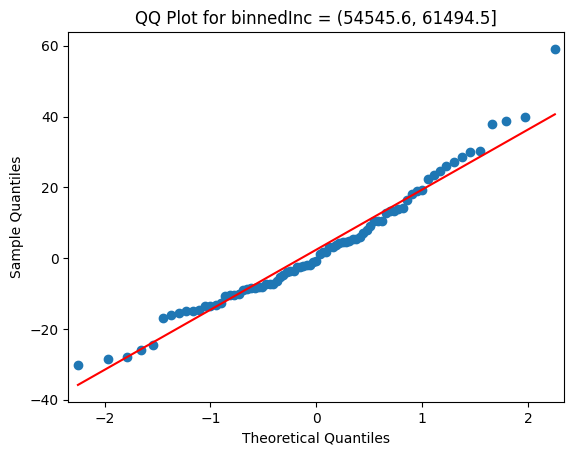

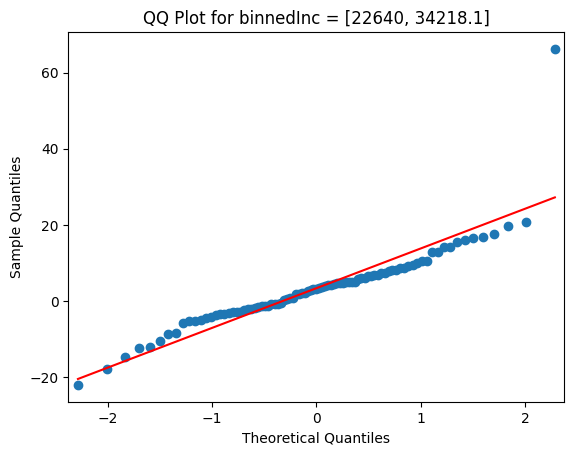

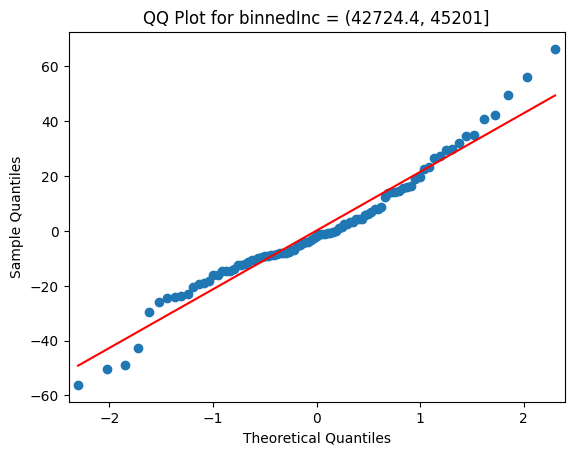

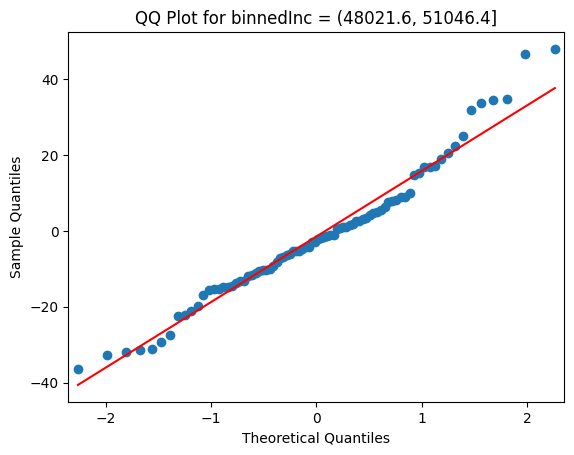

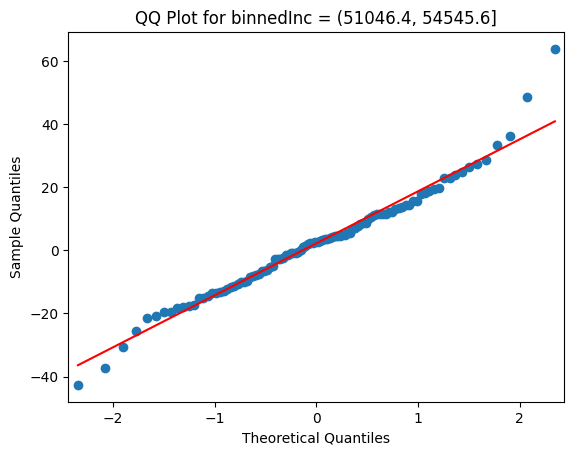

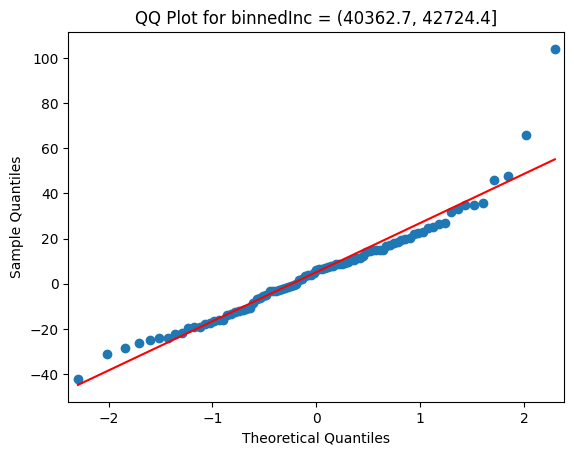

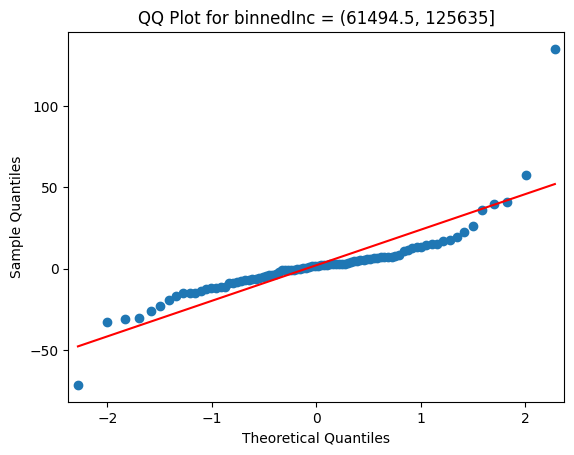

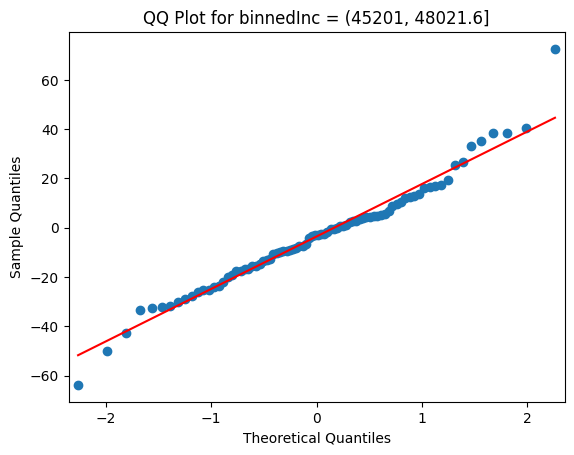

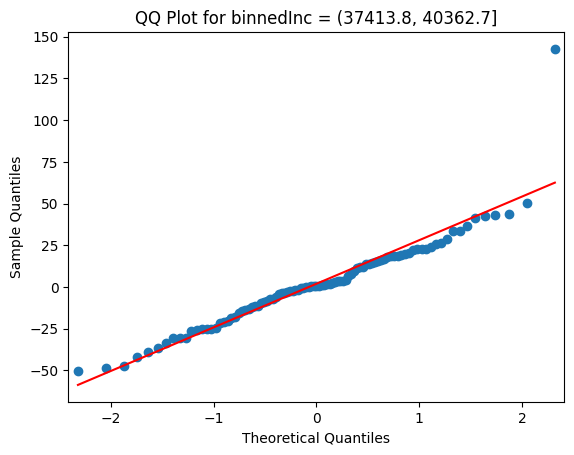

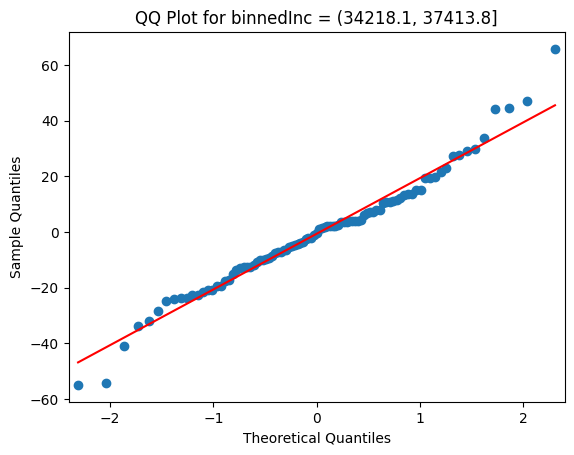

In [52]:
generate_qqplot_by_binned_inc(multi_models, df_test, features_in)

## RandomForest with Conformal Prediction

In [53]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1, oob_score=True, max_depth=int(np.ceil(np.log2(len(df_train)) - 1)), min_samples_leaf=5)
rf.fit(df_train[filtered_features], df_train['TARGET_deathRate'])

,n_estimators,100
,criterion,'squared_error'
,max_depth,11
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [54]:
rf_y_pred = rf.predict(df_test[filtered_features])
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)
rf_mse, rf_r2

(235.53046969185007, 0.7040721148397335)

In [55]:
feature_importances = pd.DataFrame(
            rf.feature_importances_,
            index=rf.feature_names_in_,
            columns=["importance"],
        ).sort_values("importance", ascending=False)

In [56]:
feature_importances

,importance
PctBachDeg25_Over,0.264747
incidenceRate,0.247765
avgAnnCount,0.197919
avgDeathsPerYear,0.106645
PercentMarried,0.030628
PctBlack,0.029238
PctPublicCoverage,0.027049
PctPrivateCoverage,0.022307
PctOtherRace,0.016654
PctAsian,0.013070


In [57]:
reg = ConformalizedRegressor(rf, alpha=0.05)

In [58]:
reg.fit(y=df_train[target], oob=True)

In [59]:
y_pred_intervals = reg.predict_interval(df_test[filtered_features])

In [60]:
y_pred = reg.predict(df_test[filtered_features])
reg.evaluate(df_test[filtered_features], df_test[target])

{'total': 906,
 'alpha': 0.05,
 'coverage_rate': 0.959,
 'interval_width_mean': 58.734,
 'mwis': 88.359,
 'mae': 10.394,
 'mbe': -1.166,
 'mse': 235.53}

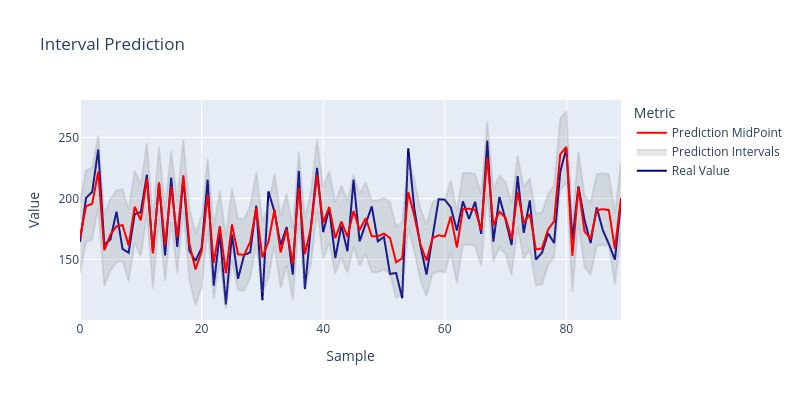

In [61]:
plot_prediction_intervals(y_pred_intervals[:90], y_pred[:90], y_test[:90], fig_type="png")